### Edgar Moises Hernandez-Gonzalez
#### 29/04/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Resize proporcional de 352x125
##### 5 ejecuciones independientes

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = %
##### Kappa = 0.

In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
import pywt
import cv2
from keras.models import Sequential
from keras.layers import (TimeDistributed, Conv2D, MaxPool2D, Flatten, LSTM,
                          Dense, Dropout)
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Espectros-STFT-Binaria/MI-EEG-ID-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RWE-DWT-Binaria/Etiquetas-ID-A01E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [7]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [8]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 2


In [0]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (125, 352) #ancho, alto
  datos = np.zeros((144,352,125))
  temporal = np.zeros((2816,1000))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      temporal[j*128:(j+1)*128, :] = abs(coef)
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [10]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100


In [11]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

0
100


In [12]:
print(x_train.shape)
print(x_test.shape)

(144, 352, 125)
(144, 352, 125)


In [13]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

50.80911524871337
36.526917436588306
0.0016808164126656904
0.0014808908865048041
3.6882503387977734
3.543660008619964


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 51.0
x_test /= 51.0

In [15]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.9962572
0.71621406
3.2957185e-05
2.9037077e-05
0.07231866
0.06948353


In [16]:
#convertir de 3D a 5D
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(144, 1, 352, 125, 1)
(144, 1, 352, 125, 1)


In [0]:
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/Modelo_ID_CNN2D_LSTM_CWT06.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=1)

In [0]:
def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu')))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(16, dropout=0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-5)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.5974221362007989
accuracy:  0.6666666865348816
kappa:  0.33333333333333337
confusion matrix:
 [[41 31]
 [17 55]]
AUC 0.7550154320987654


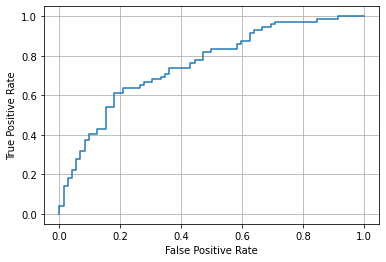

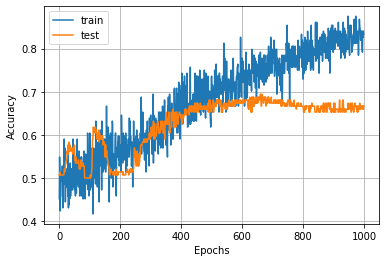

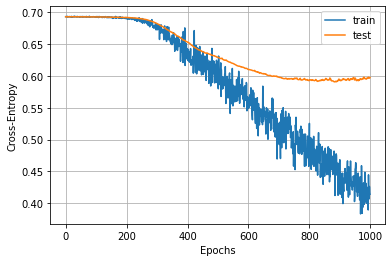

Iteration: 2
loss:  0.618758135371738
accuracy:  0.6388888955116272
kappa:  0.2777777777777778
confusion matrix:
 [[42 30]
 [22 50]]
AUC 0.7235725308641975


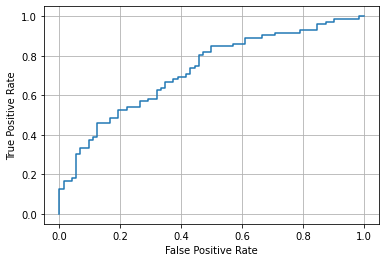

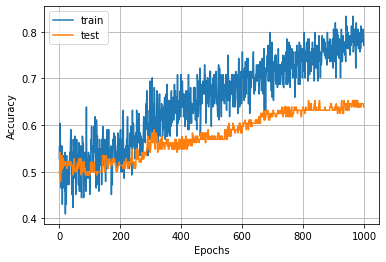

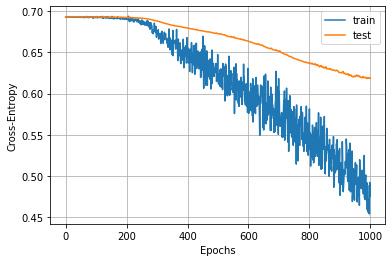


Resultados:
loss: [0.5974221362007989, 0.618758135371738]
accuracy: [0.6666666865348816, 0.6388888955116272]
kappa: [0.33333333333333337, 0.2777777777777778]


In [20]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  model = CNN_2D_LSTM_TD()

  history = model.fit(x_train, y_train, epochs=1000, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
                      #callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  fpr, tpr, thresholds = roc_curve(y_test, probabilidades)

  print("AUC", auc)
  plt.plot(fpr, tpr)
  plt.grid()
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 1, 350, 123, 32)   320       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 1, 175, 61, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 1, 173, 59, 32)    9248      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 1, 86, 29, 32)     0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, 1, 84, 27, 32)     9248      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 1, 42, 13, 32)     0         
_________________________________________________________________
time_distributed_25 (TimeDis (None, 1, 40, 11, 32)    

In [22]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.6528
std: (+/- 0.0139)
Mean Kappa: 0.3056
std: (+/- 0.0278)
Max Accuracy: 0.6667
Max Kappa: 0.3333
